In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import numpy as np
from tqdm import tqdm
from pathlib import Path
import openslide
import pandas as pd

In [4]:
from fastai.callbacks.csv_logger import CSVLogger

In [5]:
from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.helper.wsi_loader import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric, PascalVOCMetricByDistance

In [6]:
experiment_name = "Equine-Fold-3"

In [7]:
val = list(set(['26_EIPH_566482 L Berliner Blau.svs',
                 '22_EIPH_575216 Berliner Blau.svs',
                 '25_EIPH_568150 Berliner Blau.svs',
                 '20_EIPH_576150 berliner blau.svs',
                 '15_EIPH_568320 berliner blau.svs',
                 '02_EIPH_574162 berliner blau.svs',
                 '18_EIPH_574882 R Berliner Blau.svs',
                 '13_EIPH_570370 Berliner Blau.svs',
                 '16_EIPH_576172 Turnbull blue-002.svs',
                 '19_EIPH_566933 L Berliner Blau.svs',
                 '04_EIPH_567017 Turnbull blue-001.svs',
                 '29_EIPH_566481 L Turnbull blue.svs',
                 '09_EIPH_563417 L berliner blau.svs',
                 '29_EIPH_566481 L Berliner Blau.svs',
                 '20_EIPH_576150 Turnbull blue.svs',
                 '27_EIPH_571557 berliner blau.svs',
                 '11_EIPH_575697 Turnbull blue-002.svs',
                 '31_EIPH_568354 Berliner Blau.svs',
                 '07_EIPH_574882 Berliner Blau-001.svs']))

test = list(set(['14_EIPH_568381 berliner blau-001.svs',
                 '01_EIPH_563479 Berliner Blau.svs',
                 '08_EIPH_574999 Berliner Blau.svs',
                 '16_EIPH_574882 R Berliner Blau.svs',
                 '17_EIPH_575796 Berliner Blau.svs',
                 '11_EIPH_575697 Berliner Blau.svs',
                 '23_EIPH_563476 Turnbull blue.svs',
                 '01_EIPH_563479 Turnbull blue.svs',
                 '24_EIPH_576255 Turnbull blue.svs',
                 '02_EIPH_574162 Turnbull blue-001.svs',
                 '27_EIPH_571557 Turnbull blue.svs',
                 '10_EIPH_563417 R Berliner Blau.svs',
                 '08_EIPH_574999 R Turnbull blue.svs',
                 '25_EIPH_568150 Turnbull blue.svs',
                 '21_EIPH_566482 R Turnbull blue.svs',
                 '09_EIPH_563417 L Turnbull blue.svs',
                 '05_EIPH_569923 Berliner Blau.svs',
                 '05_EIPH_569923 Turnbull blue.svs',
                 '04_EIPH_567017 Berliner Blau.svs']))

train = list(set(['14_EIPH_568381 Turnbull blue.svs',
                 '23_EIPH_563476 Berliner Blau-001.svs',
                 '24_EIPH_576255 Berliner Blau.svs',
                 '30_EIPH_588355 Berliner Blau.svs',
                 '26_EIPH_566482 L Turnbull blue.svs',
                 '18_EIPH_574882 Turnbull blue-002.svs',
                 '15_EIPH_568320 Turnbull blue.svs',
                 '17_EIPH_575796 Turnbull blue.svs',
                 '30_EIPH_568355 Turnbull blue.svs',
                 '22_EIPH_575216 Turnbull blue.svs',
                 '13_EIPH_570370 Turnbull blue-001.svs',
                 '31_EIPH_568354 Turnbull blue.svs',
                 '03_EIPH_566933 R Berliner Blau neu.svs',
                 '28_EIPH_569948 L berliner blau.svs',
                 '07_EIPH_574882 left lung Turnbull blue.svs',
                 '19_EIPH_566933 L Tunrbull blue.svs',
                 '28_EIPH_569948 L Turnbull blue.svs',
                 '10_EIPH_563417 R Turnbull blue-002.svs',
                 '03_EIPH_566933 R Turnbull blue.svs']))

In [8]:
annotations_path = Path("../../Statistics/EIPH_Annotations_Equine.pkl")
annotations = pd.read_pickle(annotations_path)

annotations_train = annotations[annotations["image_name"].isin(train)]
annotations_val = annotations[annotations["image_name"].isin(val)]
annotations_test = annotations[annotations["image_name"].isin(test)]

annotations.head()

,id,image_id,image_set,image_name,grade,vector,unique_identifier,user_id,deleted
0,1433999,3530,246,07_EIPH_574882 Berliner Blau-001.svs,0,"{'x1': 32197, 'x2': 32338, 'y1': 15975, 'y2': ...",cafc4aa3-324f-4015-9451-ad7e5bee53f3,1,False
1,1434000,3530,246,07_EIPH_574882 Berliner Blau-001.svs,0,"{'x1': 23069, 'x2': 23180, 'y1': 11514, 'y2': ...",979ef20e-6228-4cb3-ac9a-aecea6ad75c1,1,False
2,1434001,3530,246,07_EIPH_574882 Berliner Blau-001.svs,0,"{'x1': 9045, 'x2': 9148, 'y1': 9711, 'y2': 9814}",ef87d780-5e2e-413e-a2ff-0712f6aa1532,1,False
3,1434002,3530,246,07_EIPH_574882 Berliner Blau-001.svs,0,"{'x1': 10538, 'x2': 10645, 'y1': 10306, 'y2': ...",0f141dc4-5589-4e5a-a504-d77e7ad94683,1,False
4,1434003,3530,246,07_EIPH_574882 Berliner Blau-001.svs,0,"{'x1': 26013, 'x2': 26114, 'y1': 20873, 'y2': ...",f56de1f1-83ff-48d6-b67a-bfc1ea4e1349,1,False


In [9]:
slides_path = Path("../../../Slides")
files = {slide.name: slide for slide in slides_path.rglob("*/*.svs") if slide.name in train + val + test}
len(files)

57

In [10]:
size = 1024 
level = 0
bs = 16
train_images = 2500
val_images = 1500

In [11]:
train_files = []
val_files = []

for image_name in annotations_train["image_name"].unique():
    
    annotations = annotations_train[annotations_train["image_name"] == image_name]
    annotations = annotations[annotations["deleted"] == False]
    
    slide_path = files[image_name]
    labels =  list(annotations["grade"])
    bboxes = [[vector["x1"], vector["y1"], vector["x2"], vector["y2"]] for vector in annotations["vector"]]
    
    train_files.append(SlideContainer(slide_path, y=[bboxes, labels],  level=level, width=size, height=size))
    
for image_name in annotations_val["image_name"].unique():
    
    annotations = annotations_val[annotations_val["image_name"] == image_name]
    annotations = annotations[annotations["deleted"] == False]
    
    slide_path = files[image_name]
    labels =  list(annotations["grade"])
    bboxes = [[vector["x1"], vector["y1"], vector["x2"], vector["y2"]] for vector in annotations["vector"]]
    
    val_files.append(SlideContainer(slide_path, y=[bboxes, labels],  level=level, width=size, height=size))
    
train_files = list(np.random.choice(train_files, train_images))
valid_files = list(np.random.choice(val_files, val_images))

In [12]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      #max_rotate=90,
                      max_lighting=0.0,
                      max_zoom=1.,
                      max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])

In [13]:
def get_y_func(x):
    return x.y

In [14]:
train =  ObjectItemListSlide(train_files, path=slides_path)
valid = ObjectItemListSlide(valid_files, path=slides_path)
item_list = ItemLists(slides_path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate).normalize()

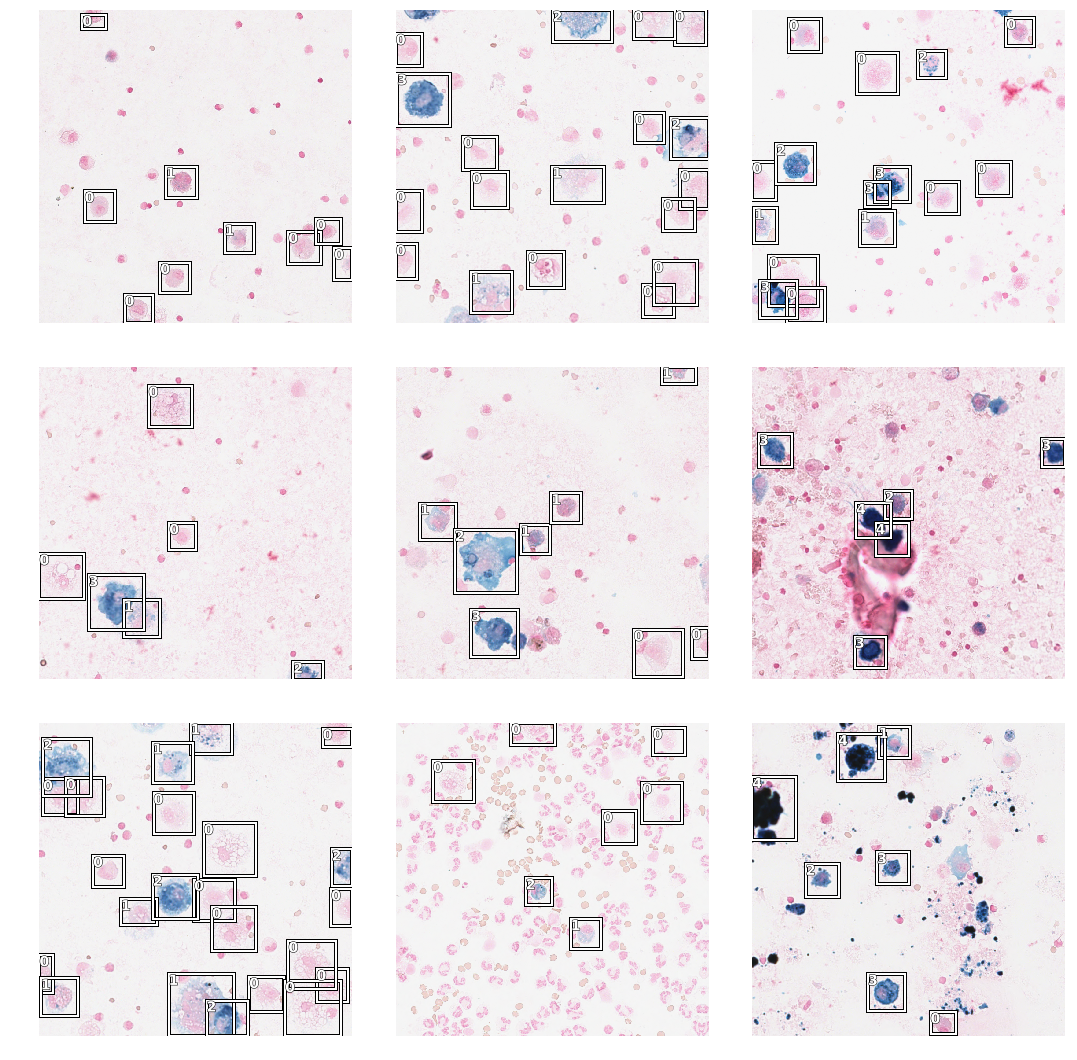

In [15]:
data.show_batch(rows=3, ds_type=DatasetType.Train, figsize=(15,15))

In [16]:
anchors = create_anchors(sizes=[(32,32)], ratios=[1], scales=[0.6, 0.7, 0.9, 1.25, 1.5])

In [17]:
crit = RetinaNetFocalLoss(anchors)
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=5, sizes=[32], chs=128, final_bias=-4., n_conv=3)

In [18]:
voc = PascalVOCMetricByDistance(anchors, size, [str(i) for i in data.train_ds.y.classes[1:]], radius=40)
learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics, partial(CSVLogger, append=True, filename=experiment_name)], #BBMetrics, ShowGraph
                metrics=[voc]
               )

In [19]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

In [20]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,pascal_voc_metric_by_distance,BBloss,focal_loss,AP-0,AP-1,AP-2,AP-3,AP-4,time
0,0.616965,0.497125,0.404988,0.128275,0.368850,0.647077,0.587458,0.443143,0.032858,0.314406,04:58
1,0.336275,0.311359,0.567363,0.064776,0.246583,0.484318,0.698313,0.673904,0.496893,0.483387,05:01
2,0.247509,0.237542,0.652207,0.054571,0.182971,0.772807,0.671297,0.649719,0.568488,0.598724,05:02


In [21]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,pascal_voc_metric_by_distance,BBloss,focal_loss,AP-0,AP-1,AP-2,AP-3,AP-4,time
0,0.247983,0.268573,0.613083,0.059713,0.208859,0.712017,0.636260,0.630075,0.518296,0.568765,05:02
1,0.300680,0.405620,0.530443,0.075766,0.329855,0.683785,0.724451,0.353035,0.386789,0.504154,05:00
2,0.329394,0.349745,0.489665,0.073079,0.276667,0.664327,0.672200,0.604781,0.383079,0.123937,05:09
3,0.309277,0.303369,0.541673,0.063213,0.240156,0.634831,0.493481,0.633478,0.615854,0.330722,05:01
4,0.275504,0.269062,0.627039,0.062715,0.206347,0.774178,0.704212,0.673483,0.488126,0.495197,05:01
5,0.234366,0.278602,0.605439,0.053794,0.224807,0.728663,0.587229,0.616182,0.382147,0.712975,05:01
6,0.208328,0.219897,0.689743,0.048728,0.171169,0.755306,0.757990,0.684273,0.610538,0.640606,05:04
7,0.194828,0.191157,0.715420,0.039203,0.151954,0.802457,0.768336,0.735795,0.623243,0.647268,04:35
8,0.170844,0.189779,0.710845,0.038685,0.151094,0.802859,0.755499,0.747563,0.641404,0.606902,04:35
9,0.165022,0.187230,0.724549,0.038311,0.148919,0.813636,0.754397,0.723080,0.672412,0.659222,04:34


In [22]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,pascal_voc_metric_by_distance,BBloss,focal_loss,AP-0,AP-1,AP-2,AP-3,AP-4,time
0,0.173592,0.217714,0.703350,0.046103,0.171611,0.774654,0.776897,0.726907,0.623140,0.615153,04:36
1,0.212410,0.258618,0.654487,0.056656,0.201962,0.768404,0.759610,0.694094,0.525230,0.525098,04:34
2,0.260469,0.262090,0.652167,0.056111,0.205979,0.726877,0.656583,0.750668,0.564593,0.562112,04:31
3,0.244256,0.256314,0.646751,0.049643,0.206671,0.659895,0.748128,0.595108,0.535346,0.695276,04:32
4,0.224203,0.242113,0.674826,0.054776,0.187337,0.768724,0.762302,0.638325,0.495707,0.709073,04:39
5,0.207473,0.208319,0.699554,0.044106,0.164213,0.714771,0.811392,0.651936,0.671500,0.648170,04:37
6,0.187146,0.202125,0.708134,0.043316,0.158809,0.791373,0.722565,0.707620,0.676971,0.642141,04:32
7,0.168256,0.182791,0.730673,0.038477,0.144313,0.796826,0.783329,0.727496,0.678453,0.667263,04:32
8,0.160820,0.175640,0.730619,0.036044,0.139596,0.794276,0.789762,0.738749,0.649745,0.680565,04:34
9,0.150319,0.180819,0.731004,0.036411,0.144408,0.804276,0.760965,0.740829,0.663686,0.685266,04:34


In [23]:
import pickle

stats = {"anchors": anchors,
         "mean": to_np(data.stats[0]),
         "std": to_np(data.stats[1]),
         "size": size,
         "n_classes": 6,
         "n_anchors": 5,
         "sizes": [32],
         "chs": 128,
         "encoder": "RN-18",
         "n_conv": 3,
         "level": 0,
         "model": get_model(learn.model).state_dict()
        }

torch.save(stats, "{}.p".format(experiment_name))

In [24]:
def rescale_box(bboxes, size: Tensor):
    bboxes[:, :2] = bboxes[:, :2] - bboxes[:, 2:] / 2
    bboxes[:, :2] = (bboxes[:, :2] + 1) * size / 2
    bboxes[:, 2:] = bboxes[:, 2:] * size / 2
    bboxes = bboxes.long()
    return bboxes

In [25]:
detect_thresh = 0.1 
nms_thresh = 0.3

In [26]:
import torchvision.transforms as transforms

debug_level = 1
result_boxes = {}
detect_thresh 
with torch.no_grad():
    for slide_path in tqdm(test):
        
        slide_container = SlideContainer(files[slide_path], y=[[],[]],  level=level, width=size, height=size)

        result_boxes[slide_container.file.name] = []

        for x in range(0, slide_container.slide.level_dimensions[level][0] - 2 * size, 750): #int(size / 2)
            for y in range(0, slide_container.slide.level_dimensions[level][1] - 2 * size, 750): #int(size / 2)
                x_real = x  # * slide_container.down_factor, \
                y_real = y  # * slide_container.down_factor

                patch_ori = slide_container.get_patch(x, y)
                patch = pil2tensor(patch_ori / 255., np.float32)

                patch = transforms.Normalize(data.stats[0], data.stats[1])(patch)

                class_pred_batch, bbox_pred_batch, _ = learn.model.eval()(
                    patch[None, :, :, :].cuda())
                for clas_pred, bbox_pred in zip(class_pred_batch, bbox_pred_batch):

                    bbox_pred, scores, preds = process_output(clas_pred, bbox_pred, anchors, detect_thresh)

                    if bbox_pred is not None:
                        to_keep = nms(bbox_pred, scores, nms_thresh)
                        bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()

                        t_sz = torch.Tensor([size, size])[None].float()

                        bbox_pred = rescale_box(bbox_pred, t_sz)

                        patch_ori = patch_ori.astype(np.uint8)
                        for box, pred, score in zip(bbox_pred, preds, scores):
                            y_box, x_box = box[:2]
                            h, w = box[2:4]

                            result_boxes[slide_container.file.name].append(np.array([x_box + x_real, y_box + y_real,
                                                                                     x_box + x_real + w, y_box + y_real + h,
                                                                                     pred, score]))


        pickle.dump(result_boxes, open(str("inference_results_{}.p".format(experiment_name)), "wb"))

100%|██████████| 19/19 [1:34:28<00:00, 310.63s/it]
